In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load training data

The training data for building the model will be from the previous run of extracting keywords from NLTK.



In [0]:
import pandas as pd
filepath = '/content/drive/My Drive/final-project/keywords/keyword-context.txt'
df = pd.read_csv(filepath, names=['context', 'keywords'], sep=',')   
print(df.iloc[0])

context     borqs beijing qualified high technology enterp...
keywords                                        borqs beijing
Name: 0, dtype: object


# Generate Test and Train Data

First, we are going to split the data into a training and testing set which will allow us to evaluate the accuracy and see if your model generalizes well. 

This means whether the model is able to perform well on data it has not seen before.

In [0]:
from sklearn.model_selection import train_test_split

sentences = df['context'].values
y = df['keywords'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

# Building the Keras Model

Keras supports two main types of models. You have the Sequential model API and the functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where we can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that we are already familiar with.

Build a helper function to visualize the loss and accuracy for the training and testing data based on the History callback. This callback, which is automatically applied to each Keras model, records the loss and additional metrics that can be added in the .fit() method. In this case, we are only interested in the accuracy. This helper function employs the matplotlib plotting library:

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Text preprocessing and sequence preprocessing.

Now we need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for text preprocessing and sequence preprocessing which you can employ to prepare your text.



#Convolutional Neural Networks (CNN)

 CNN has hidden layers which are called convolutional layers. 

This is the very core of the technique, the mathematical process of convolution. With each convolutional layer the network is able to detect more complex patterns. 

When we are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

In [0]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_154 (Embedding)    (None, 100, 100)          498100    
_________________________________________________________________
conv1d_149 (Conv1D)          (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_153 (Gl (None, 128)               0         
_________________________________________________________________
dense_323 (Dense)            (None, 10)                1290      
_________________________________________________________________
dense_324 (Dense)            (None, 1)                 11        
Total params: 563,529
Trainable params: 563,529
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0067
Testing Accuracy:  0.0006


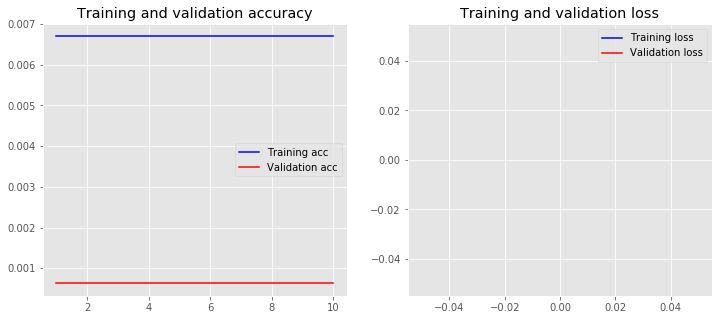

In [0]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#Hyperparameters Optimization

One crucial steps of deep learning and working with neural networks is hyperparameter optimization.

One popular method for hyperparameter optimization is grid search. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, random search, which you’ll see in action here, simply takes random combinations of parameters.

In order to apply random search with Keras, we use the KerasClassifier which serves as a wrapper for the scikit-learn API. With this wrapper we are able to use the various tools available with scikit-learn like cross-validation. The class  is RandomizedSearchCV which implements random search with cross-validation. Cross-validation is a way to validate the model and take the whole data set and separate it into multiple testing and training data sets.

There are various types of cross-validation. One type is the k-fold cross-validation . In this type the data set is partitioned into k equal sized sets where one set is used for testing and the rest of the partitions are used for training. This enables you to run k different runs, where each partition is once used as a testing set. So, the higher k is the more accurate the model evaluation is, but the smaller each testing set is.

First step for KerasClassifier is to have a function that creates a Keras model. We will use the previous model, but we will allow various parameters to be set for the hyperparameter optimization:

In [0]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

The resulting instance and the parameter grid are then used as the estimator in the RandomSearchCV class. Additionally, we choose the number of folds in the k-folds cross-validation, which is in this case 4.  Besides the RandomSearchCV and KerasClassifier, there is a little block of code handling the evaluation:

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = '/content/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
sentences = df['context'].values
y = df['keywords'].values

# Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(
sentences, y, test_size=0.25, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

# Save and evaluate results
with open(output_file, 'a') as f:
  s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
  output_string = s.format(
            'edgar',
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
  print(output_string)
  f.write(output_string)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 18.7min finished


Running edgar data set
Best Accuracy : 0.0050
{'vocab_size': 4981, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.0044




# Evaluating the performance of different model.

1) Below is a simple sequential model with 1 layer.


In [0]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelEncoder

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
model.summary()
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_train =le.fit_transform(y_train)
history = model.fit(X_train, y_train,
                    epochs=25,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {}".format(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_311 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_312 (Dense)            (None, 1)                 11        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
Train on 4778 samples, validate on 1593 samples
Epoch 1/25
4778/4778 [==============================] - 16s 3ms/step - loss: nan - acc: 0.0067 - val_loss: nan - val_acc: 6.2775e-04
Epoch 2/25
4778/4778 [==============================] - 3s 613us/step - loss: nan - acc: 0.0067 - val_loss: nan - val_acc: 6.2775e-04
Epoch 3/25
4778/4778 [==============================] - 3s 616us/step - loss: nan - acc: 0.0067 - val_loss: nan - val_acc: 6.2775e-04
Epoch 4/25
4778/4778 [==============================] - 3s 612us/step - loss: nan - acc

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


# What Is a Word Embedding?
Text is considered a form of sequence data similar to time series data that you would have in weather data or financial data. In the previous BOW model, you have seen how to represent a whole sequence of words as a single feature vector. 

 There are various ways to vectorize text, such as:

- Words represented by each word as a vector

- Characters represented by each character as a vector

- N-grams of words/characters represented as a vector (N-grams are overlapping groups of multiple succeeding words/characters in the text)


Below we will use Keras for word embedding as well the he glove word embedding to see if they make a difference to the model.

In [0]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_149 (Embedding)    (None, 100, 50)           249050    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_313 (Dense)            (None, 10)                50010     
_________________________________________________________________
dense_314 (Dense)            (None, 1)                 11        
Total params: 299,071
Trainable params: 299,071
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0067
Testing Accuracy:  0.0006


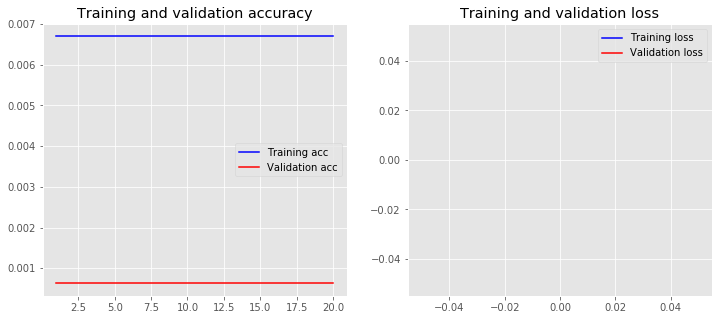

In [0]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_train =le.fit_transform(y_train)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_150 (Embedding)    (None, 100, 50)           249050    
_________________________________________________________________
global_max_pooling1d_149 (Gl (None, 50)                0         
_________________________________________________________________
dense_315 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_316 (Dense)            (None, 1)                 11        
Total params: 249,571
Trainable params: 249,571
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0067
Testing Accuracy:  0.0006


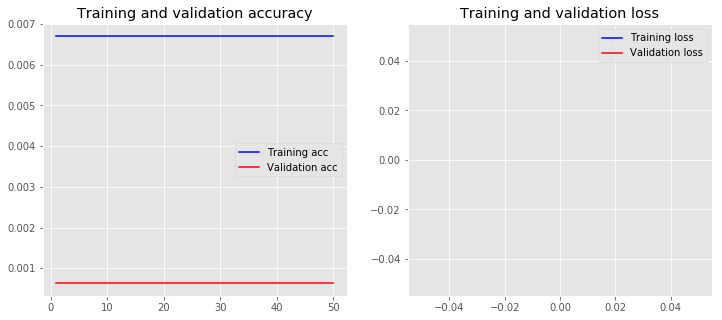

In [0]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_train =le.fit_transform(y_train)
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
  '/content/drive/My Drive/final-project/raw/glove.6B.100d.txt',
   tokenizer.word_index, embedding_dim)

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_152 (Embedding)    (None, 100, 100)          498100    
_________________________________________________________________
global_max_pooling1d_151 (Gl (None, 100)               0         
_________________________________________________________________
dense_319 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_320 (Dense)            (None, 1)                 11        
Total params: 499,121
Trainable params: 1,021
Non-trainable params: 498,100
_________________________________________________________________


Training Accuracy: 0.0067
Testing Accuracy:  0.0006


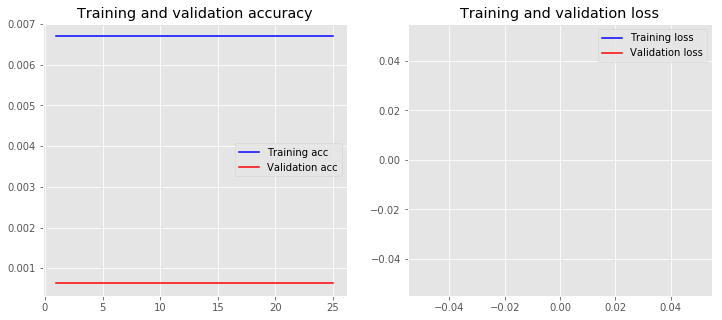

In [0]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_train =le.fit_transform(y_train)
history = model.fit(X_train, y_train,
                    epochs=25,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_153 (Embedding)    (None, 100, 100)          498100    
_________________________________________________________________
global_max_pooling1d_152 (Gl (None, 100)               0         
_________________________________________________________________
dense_321 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_322 (Dense)            (None, 1)                 11        
Total params: 499,121
Trainable params: 499,121
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.0067
Testing Accuracy:  0.0006


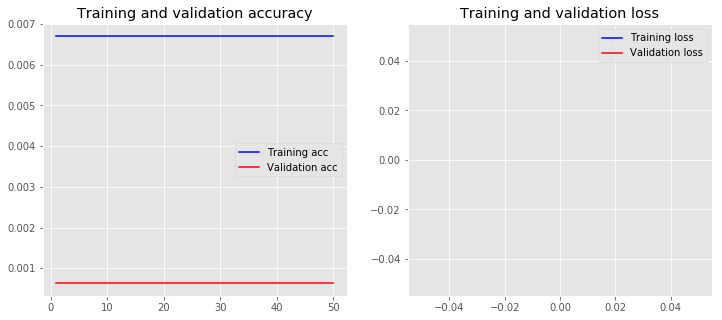

In [0]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)